# Final Tutorial: Analysis of Professor Performance at UMD
Collaborators: Albert Chen, Alex Chen, Aaron Lin, Srujan Penikelapati

# Table of Contents

* [Introduction](#introduction)
* [Step 1: Data Collection](#data-collection)
    * [Imports](#imports)
    * [PlanetTerp](#planetterp)
    * [Diamondback](#diamondback)
    * [Combining PlanetTerp Data](#combining-planetterp-data)
* [Step 2: Data Cleaning](#data-cleaning)
    * [Duplicates in Diamondback](#duplicates-in-diamondback)
    * [Matching Names](#matching-names)
    * [Getting Departments](#getting-departments)
    * [Missing Professors](#missing-professors)
    * [Professors with Missing Years](#professors-with-missing-years)
* [Exploratory Analysis](#exploratory-analysis)
* [Analysis, Hypothesis Testing, and ML](#analysis-hypothesis-testing-and-ml)

# Introduction <a class="anchor" id = "introduction"></a>

Data science is an interdisciplinary field that involves the collection, cleaning, visualization, analysis, and interpretation of complex data sets. The ultimate goal of data science is to extract meaningful and actionable insights from data that can inform decision-making, and improve outcomes across a variety of industries. In this tutorial, we will using a data science project of our own to guide the reader through the data science lifecycle, which is listed above in the Table of Contents. 

Faculty are the lifeblood of any university. They conduct cutting-edge research to discover new insights that push the boundary of the field they are studying. They also teach classes, helping students learn new skills and knowledge that will benefit them in their professional lives. As in any occupation, professors vary in the quality of their research and their teaching ability. This directly impacts the quality of education that students who take their classes receive. Students understand this clearly and will spend hours looking for the right professor that will give them an engaging and informative semester.

This is why we decided to analyze the effectiveness of professors at UMD. The analysis done in the project can answer questions that administrators and students have on the state of professors at UMD. For example, a UMD administrator might want to know whether a professor with a high salary and many years of experience at UMD teaches better than other professors. A student might be faced with picking between two professors teaching the same course, and want to know which one would would help them get a better GPA.

To analyze the effectiveness of the professors, we decided to look at two independent variables: the number of years they've been teaching and the salary that they get paid. The dependent variable, effectiveness, will be measured by the professors' GPAs (Grade Point Average) and the student reviews. These two variables indicate how well the students understood the information, along with how effectively the professor taught a course.

<img src="sheena_sheep.png" alt="Sheena_Sheep" />

# Data Collection <a class="anchor" id = "data-collection"></a>

Data collection is the first and most critical step in the data science process. It involves gathering and organizing data from various sources. One popular method of collecting data is through GET requests, which are used to retrieve data from web applications via the HTTPS protocol. However, this process can be time consuming, as large amounts of data are being sent over the internet, so this data is downloaded and stored locally for us to use.

### Imports <a class="anchor" id = "imports"></a>

These are the various libraries that will be used throughout the course of this tutorial. This project utilizes Python and Jupyter notebook, with a majority of the data manipulation being done through the [Pandas](https://pandas.pydata.org/) library. This library is  one the most important and frequently used libraries in this tutorial, as it allows us to store data in dataframes. These dataframes are similar to 2D matricies or tables, and the Pandas library has many built in functions that makes data manipulation efficient and effective. The various other libraries help us retrieve, manage, and analyze our data.

In [2]:
import pandas as pd
import requests
import os
from pathlib import Path
import os.path
from statsmodels.formula.api import *
import matplotlib.pyplot as plt
from sklearn import linear_model
from ggplot import *
import numpy as np
import ast
from bs4 import BeautifulSoup
from IPython.display import clear_output, display, HTML

### Data Collection: PlanetTerp <a class="anchor" id = "planetterp"></a>

Since we are looking for information on a professor's grade distributions, student reviews of that professor, and the number of years a professor has been teaching, [PlanetTerp](https://planetterp.com/) was a natural place to look for the information we needed. The data there is specific to UMD and the website itself was made by students, who were generous enough to provide us a [documented API](https://planetterp.com/api/) that we could use. We used GET requests to the PlanetTerp API in order to get the information from the website, before storing it into dataframes. However, we quickly discovered that performing all of these requests could take excessive amounts of time. As such, we decided to store our data into csv files and then read from those files locally rather than constantly re-requesting the website. We did this by checking if our csv files already existed, and if they did we could simply read from those files, only requesting from the site if the csv files we were looking for didn't exist. As such, all of the data used from here on out in this tutorial will be accurate up until April 28th, 2023, as that is the last time we actually requested information from PlanetTerp itself. 

In [3]:
reviews_exist = os.path.exists("src/1_collect_data/planet_terp_data/PT_review_data.csv")
grades_exist = os.path.exists("src/1_collect_data/planet_terp_data/PT_grade_data.csv")

In [4]:
if reviews_exist == False:
    reviews = []
    done = False
    offset = 0
    # maximum limit is 100, keep requesting until all of the data has been collected
    while done == False:
        r = requests.get("https://planetterp.com/api/v1/professors", params = {"offset":offset, "reviews": "true", "limit":100},)
        if r.json() == []:
            done = True
        else:
            reviews.append(r.json())
            offset = offset+100
    df = pd.DataFrame()
    count = 0
    # separate out data, each review gets its own row
    for i in reviews:
        for j in i:
            if j.get("reviews") != []:
                for k in j.get("reviews"):
                    # only add review if it is for a professor, not a TA, and there is a course attached to it
                    if k.get("course") != None and j.get("type") == "professor":
                        df.at[count, "name"] = j.get("name")
                        df.at[count, "slug"] = j.get("slug")
                        df.at[count, "type"] = j.get("type")
                        df.at[count, "course"] = k.get("course")
                        df.at[count, "rating"] = k.get("rating")
                        df.at[count, "review"] = k.get("review")
                        df.at[count, "date"] = k.get("created")[:10]
                        count = count + 1

    df = df.sort_values(by=["name","course"])
    df.to_csv("src/1_collect_data/PT_review_data.csv", encoding='utf-8', index=False)

In [5]:
if grades_exist == False:
    offset = 0
    grades = []
    professors = df["name"].drop_duplicates()
    # get grade data for each professor
    for prof in professors:
        r = requests.get("https://planetterp.com/api/v1/grades", params = {"offset":offset, "reviews": "true", "limit":100, "professor": prof})
        grades.append(r.json())
    grade_df = pd.DataFrame()
    count = 0
    # each semester of each course gets its own row in the dataframe
    for i in grades:
        if i != []:
            for j in i:
                grade_df.at[count, "professor"] = j.get("professor")
                grade_df.at[count, "course"] = j.get("course")
                grade_df.at[count, "semester"] = j.get("semester")
                grade_df.at[count, "section"] = j.get("section")
                grade_df.at[count, "A+"] = j.get("A+")
                grade_df.at[count, "A"] = j.get("A")
                grade_df.at[count, "A-"] = j.get("A-")
                grade_df.at[count, "B+"] = j.get("B+")
                grade_df.at[count, "B"] = j.get("B")
                grade_df.at[count, "B-"] = j.get("B-")
                grade_df.at[count, "C+"] = j.get("C+")
                grade_df.at[count, "C"] = j.get("C")
                grade_df.at[count, "C-"] = j.get("C-")
                grade_df.at[count, "D+"] = j.get("D+")
                grade_df.at[count, "D"] = j.get("D")
                grade_df.at[count, "D-"] = j.get("D-")
                grade_df.at[count, "F"] = j.get("F")
                grade_df.at[count, "W"] = j.get("W")
                grade_df.at[count, "Other"] = j.get("Other")
                count = count + 1
    
    grade_df = grade_df.sort_values(by=["professor","course"])
    grade_df.to_csv("src/1_collect_data/PT_grade_data.csv", encoding = "utf-8", index = False)

### Diamondback <a class="anchor" id = "diamondback"></a>

The other information that we need is a way to find out how much a teacher is earning at the University of Maryland. [The Diamondback](https://dbknews.com/) published a [salary guide](https://salaryguide.dbknews.com/) in 2022, which has its own [API](https://api.dbknews.com/docs/#/salary). From here, we were then able to perform the same process of using GET requests to read the salary data for each year from 2013 to 2022. However, it was slightly more complicated, since the API would only show the salary data one page (10 entries) at a time. We also performed the same procedure of writing our data to csv files to read from locally, as all of these requests also took very long to perform. The data used from here on out is accurate up until 2022.

In [6]:
salaries_exist = os.path.exists("src/1_collect_data/salary_data/DB_combined_data.csv")

In [7]:
def combine(group):
    years = group['year'].tolist()
    salaries = group['Salary'].tolist()
    salaries = [float(s.replace(",","")[1:]) for s in salaries]
    departments = group['Department'].tolist()
    
    i = 0
    while i < len(years) - 1:
        if (years[i] == years[i+1]):
            if salaries[i] != salaries[i + 1]:
                salaries[i] = salaries[i] + salaries[i + 1]
            years.pop(i+1)
            salaries.pop(i+1)
            departments.pop(i+1)
        else:
            i += 1

    return pd.Series({
        'years_taught': years,
        'salaries': salaries,
        'departments': departments,
    })

if salaries_exist == False:
    # get years that api is valid for
    r_years = requests.get("https://api.dbknews.com/salary/years")
    years = r_years.json()["data"]

    df = pd.DataFrame()

    # for each year, get salary data
    for year in years:
        r = requests.get(f"https://api.dbknews.com/salary/year/{year}")

        # number of faculty
        count = r.json()["count"]
        year_df = pd.DataFrame()
        page = 0

        while page * 10 < count:
            page += 1

            # get salary data for 1 page
            r = requests.get(f"https://api.dbknews.com/salary/year/{year}?page={page}")
            page_df = pd.DataFrame.from_dict(r.json()["data"])

            # remove division and title columns, modify department col, and add year
            page_df = page_df.drop(['Division', "Title"], axis=1)
            page_df["Department"] = page_df["Department"].str.slice(stop=4)
            page_df["year"] = [f"{year}"] * len(page_df.index)
            year_df = pd.concat([year_df, page_df], axis=0)

        print(f"year {year} finished")
        year_df.to_csv(f'src/1_collect_data/salary_data/{year}data.csv', index=False)

    # get data for all of the years into one dataframe
    for year in years:
        year_df = pd.read_csv(f'src/1_collect_data/salary_data/{year}data.csv')
        year_df['Employee'] = year_df['Employee'].str.replace('\n', ' ')
        df = pd.concat([df, year_df], axis=0)

    # combine all of the information for a single professor into one row
    df_grouped = df.groupby(['Employee']).apply(combine).reset_index()

    df_grouped['name'] = df_grouped['Employee'].apply(lambda x: (x.split(', ')[1].split(" ")[0]+ ' ' + x.split(', ')[0].split(" ")[-1]).upper())

    df_grouped.to_csv(f'src/1_collect_data/salary_data/DB_combined_data.csv', index=False)

In [8]:
reviews_df = pd.read_csv("src/1_collect_data/planet_terp_data/PT_review_data.csv")
grades_df = pd.read_csv("src/1_collect_data/planet_terp_data/PT_grade_data.csv")
salaries_df = pd.read_csv("src/1_collect_data/salary_data/DB_combined_data.csv")

In [9]:
reviews_df.head()

,name,slug,type,course,rating,review,date
0,A Anthony,anthony,professor,AMST203,1.0,"By far the worst professor I’ve ever had, and ...",2018-08-17
1,A Kruglanski,kruglanski,professor,PSYC489H,2.0,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",2015-09-07
2,A Sharma,sharma_a,professor,ASTR300,2.0,"Very boring, it's hard to maintain your focus ...",2019-04-04
3,A Sharma,sharma_a,professor,ASTR300,1.0,You'll pass but this class will be the most bo...,2019-05-26
4,A Sharma,sharma_a,professor,ASTR300,1.0,Rather difficult course. Class is extremely bo...,2019-12-08


In [10]:
grades_df.head()

,professor,course,semester,section,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other
0,A Anthony,AMST202,201608,0101,1.0,2.0,1.0,2.0,5.0,1.0,2.0,3.0,5.0,0.0,0.0,0.0,2.0,4.0,0.0
1,A Anthony,AMST202,201701,0101,0.0,1.0,4.0,3.0,3.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,A Anthony,AMST203,201708,FCH1,0.0,2.0,1.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,A Anthony,AMST203,201708,FCH2,0.0,0.0,1.0,4.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
4,A Anthony,AMST203,201801,0201,1.0,3.0,1.0,2.0,4.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,2.0,6.0,0.0


In [11]:
salaries_df.head()

,Employee,years_taught,salaries,departments,name
0,"A Karim, Eaman","[2018, 2019]","[48000.0, 48960.0]","['ENGR', 'ENGR']",EAMAN KARIM
1,"A'Hearn, Michael F.","[2013, 2014, 2015, 2016, 2017]","[125817.0, 130849.69, 145530.01, 155925.01, 13...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS']",MICHAEL A'HEARN
2,"AMIN, MOHAMMED NURUL",[2015],[46500.0],['CMNS'],MOHAMMED AMIN
3,"Aarhus, William H","[2016, 2017, 2018, 2019, 2020, 2021, 2022]","[75000.0, 75750.0, 75750.0, 77265.0, 80780.68,...","['SVPA', 'SVPA', 'SVPA', 'SVPA', 'SVPA', 'EXST...",WILLIAM AARHUS
4,"Abadi, Berhane",[2022],[31278.0],['VPSA'],BERHANE ABADI


### Combining PlanetTerp Data <a class="anchor" id = "combining-planetterp-data"></a>

Eventually, we would like to have all of our data come together into one single dataframe for us to manipulate. Since student reviews and grades are currently being stored in separate dataframes, the first step towards our end goal is logically to combine these two dataframes into one, as they both come from the same data source. We would like to separate all of the data we currently have, grouping them by a specific course taught by a specific professor in a specific semester. The grade data from PlanetTerp is stored in this format, with each professor's classes being separated out into every semester they taught the class. However, the reviews left on the website don't have the semester that the student took the class in listed. As such, we have to make assumptions for what semester a student took the class they are reviewing based on the date that they left their review. We assume any review left from September to December are for fall classes, January are for winter classes, February to May are for spring classes, and June to August are for summer classes.

In [12]:
for index, row in reviews_df.iterrows():
    reviews_df.at[index, "year"] = str(reviews_df.at[index, "date"])[:4]
    #getting the month from date formatted as YYYY-MM-DD
    if int(str(reviews_df.at[index, "date"])[5:7]) > 8:
        reviews_df.at[index, "season"] = "fall"
    elif str(reviews_df.at[index, "date"])[5:7] == "01":
        reviews_df.at[index, "season"] = "winter"
    elif str(reviews_df.at[index, "date"])[5:7] == "06" or str(reviews_df.at[index, "date"])[5:7] == "07" or str(reviews_df.at[index, "date"])[5:7] == "08" :
        reviews_df.at[index, "season"] = "summer"
    else:
        reviews_df.at[index, "season"] = "spring"

reviews_df.head()

,name,slug,type,course,rating,review,date,year,season
0,A Anthony,anthony,professor,AMST203,1.0,"By far the worst professor I’ve ever had, and ...",2018-08-17,2018,summer
1,A Kruglanski,kruglanski,professor,PSYC489H,2.0,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti...",2015-09-07,2015,fall
2,A Sharma,sharma_a,professor,ASTR300,2.0,"Very boring, it's hard to maintain your focus ...",2019-04-04,2019,spring
3,A Sharma,sharma_a,professor,ASTR300,1.0,You'll pass but this class will be the most bo...,2019-05-26,2019,spring
4,A Sharma,sharma_a,professor,ASTR300,1.0,Rather difficult course. Class is extremely bo...,2019-12-08,2019,fall


We then group all of the reviews for a certain professor's class that were detected to be from the same semester together, averaging out the ratings for that semester.

In [13]:
# sort by the following to ensure that reviews corresponding to the same semester get grouped together
reviews_df = reviews_df.sort_values(by = ["name", "course", "year", "season"], ignore_index = True)

average_reviews_df = pd.DataFrame()

values_to_check = ["name", "course", "year", "season"]
curr = [reviews_df.at[0, "name"], reviews_df.at[0, "course"], reviews_df.at[0, "year"], reviews_df.at[0, "season"]]
count = 0
averages = [0, 0]
for index, row in reviews_df.iterrows():
    match = True
    # see if the next row in the dataframe is for the current semester
    for i in range(4):
        if curr[i] != reviews_df.at[index, values_to_check[i]]:
            match = False
    if not match:
        # once it is not a match, write the current accumulated information to the dataframe and reset
        for i in range(4):
            average_reviews_df.at[count, values_to_check[i]] = curr[i]
            curr[i] = reviews_df.at[index, values_to_check[i]]
        average_reviews_df.at[count, "average_rating"] = averages[0]/averages[1]
        average_reviews_df.at[count, "num_reviews"] = averages[1]
        count = count + 1
        averages = [0, 0]
    averages[0] = averages[0] + reviews_df.at[index, "rating"]
    averages[1] = averages[1] + 1
# add in the last row
for i in range(4):
    average_reviews_df.at[count, values_to_check[i]] = curr[i]
average_reviews_df.at[count, "average_rating"] = averages[0]/averages[1]
average_reviews_df.at[count, "num_reviews"] = averages[1]

average_reviews_df.head()

,name,course,year,season,average_rating,num_reviews
0,A Anthony,AMST203,2018,summer,1.0,1.0
1,A Kruglanski,PSYC489H,2015,fall,2.0,1.0
2,A Sharma,ASTR300,2019,fall,1.0,1.0
3,A Sharma,ASTR300,2019,spring,1.5,2.0
4,A Sharma,ASTR300,2020,fall,2.0,1.0


The semester information for grades are stored implicitly on PlanetTerp. The format is year, followed by either 08 or 01, corresponding to either fall or spring semester. For example, grade information for the fall 2021 semester would be stored under the tag of 202108. As such, we can extract this information and continue with the same process as above, grouping grades from semesters that are the same together

In [14]:
for index, row in grades_df.iterrows():
    grades_df.at[index, "year"] = str(grades_df.at[index, "semester"])[:4]
    if str(grades_df.at[index, "semester"])[4:] == "08":
        grades_df.at[index, "season"] = "fall"
    else:
        grades_df.at[index, "season"] = "spring"

In [15]:
# sort by the following to ensure that grades corresponding to the same semester get grouped together
grades_df = grades_df.sort_values(by = ["professor", "course", "year", "season"], ignore_index = True)

average_grades_df = pd.DataFrame()
# GPA values for each letter grade
gpa = {"A+":4.0, "A":4.0, "A-":3.7,"B+":3.3, "B":3.0, "B-":2.7, "C+":2.3, "C":2.0, "C-":1.7, "D+":1.3, "D":1.0, "D-":0.7, "F":0.0}

values_to_check = ["professor", "course", "year", "season"]
curr = [grades_df.at[0, "professor"], grades_df.at[0, "course"], grades_df.at[0, "year"], grades_df.at[0, "season"]]
count = 0
averages = [0, 0]
for index, row in grades_df.iterrows():
    match = True
    # see if the next row in the dataframe is for the current semester
    for i in range(4):
        if curr[i] != grades_df.at[index, values_to_check[i]]:
            match = False
    if not match:
        # once it is not a match, write the current accumulated information to the dataframe and reset
        for i in range(4):
            if averages[1] != 0:
                average_grades_df.at[count, values_to_check[i]] = curr[i]
            curr[i] = grades_df.at[index, values_to_check[i]]
        # it is possible for the number of students taking a class to be 0, this would occur when all of the students
        # in a class have grades corresponding to W or Other, neither of which have a GPA value
        if averages[1] != 0:
            average_grades_df.at[count, "average_gpa"] = averages[0]/averages[1]
            average_grades_df.at[count, "num_students"] = averages[1]
            count = count + 1
        averages = [0, 0]
    for i in gpa.keys():
        averages[0] = averages[0] + gpa.get(i)*grades_df.at[index, i]
        averages[1] = averages[1] + grades_df.at[index, i]
# add in the last row
for i in range(4):
    if averages[1] != 0:
        average_grades_df.at[count, values_to_check[i]] = curr[i]
if averages[1] != 0:
    average_grades_df.at[count, "average_gpa"] = averages[0]/averages[1]
    average_grades_df.at[count, "num_students"] = averages[1]


average_grades_df.head()

,professor,course,year,season,average_gpa,num_students
0,A Anthony,AMST202,2016,fall,2.462500,24.0
1,A Anthony,AMST202,2017,spring,2.934783,23.0
2,A Anthony,AMST203,2017,fall,2.796429,28.0
3,A Anthony,AMST203,2018,fall,3.204651,43.0
4,A Anthony,AMST203,2018,spring,2.476190,21.0


Finally, we can join these two dataframes together, before combining them so that each professor corresponds to one row in the dataframe, storing all of their review and grade information in arrays that can be exploded out in the future. The reason for doing this is in order to more easily match with the data from the Diamondback. Further down the line, we will then reseparate our data out to perform the necessary analysis.

In [16]:
average_grades_df = average_grades_df.rename(columns = {"professor" : "name"})

both_averages_df = pd.merge(
    average_reviews_df,
    average_grades_df,
    how = "outer",
    on = ["name", "course", "year", "season"]
)

both_averages_df.head()

,name,course,year,season,average_rating,num_reviews,average_gpa,num_students
0,A Anthony,AMST203,2018,summer,1.0,1.0,NaN,NaN
1,A Kruglanski,PSYC489H,2015,fall,2.0,1.0,NaN,NaN
2,A Sharma,ASTR300,2019,fall,1.0,1.0,NaN,NaN
3,A Sharma,ASTR300,2019,spring,1.5,2.0,2.850877,57.0
4,A Sharma,ASTR300,2020,fall,2.0,1.0,NaN,NaN


In [17]:
def combine(group):
     return pd.Series({
        'course': group['course'].tolist(),
        'semester': [a + " " + b for a, b in zip(group['season'], group['year'])],
        'average_rating': group['average_rating'].tolist(),
        'num_reviews': group['num_reviews'].tolist(),
        'average_gpa': [round(x, 2) for x in group['average_gpa']],
        'num_students': [int(x) for x in np.nan_to_num(group['num_students'])]
    })
df_grouped = both_averages_df.groupby(['name']).apply(combine).reset_index()
df_grouped["name"] = df_grouped["name"].apply(lambda x: x.split()[0].upper()) + " " +df_grouped["name"].apply(lambda x: x.split()[-1].upper())

if os.path.exists("src/1_collect_data/planet_terp_data/PT_grade_data.csv") == False:
    df_grouped.to_csv(f'src/1_collect_data/planet_terp_data/PT_combined_data.csv', index=False)

df_grouped.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students
0,A ANTHONY,"[AMST203, AMST202, AMST202, AMST203, AMST203, ...","[summer 2018, fall 2016, spring 2017, fall 201...","[1.0, nan, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, nan]","[nan, 2.46, 2.93, 2.8, 3.2, 2.48]","[0, 24, 23, 28, 43, 21]"
1,A KRUGLANSKI,"[PSYC489H, PSYC489H, PSYC489H, PSYC489T, PSYC4...","[fall 2015, spring 2014, spring 2015, spring 2...","[2.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 3.51, 3.55, 3.89, 3.46, 3.56, 3.52, 3.45...","[0, 16, 8, 17, 20, 14, 19, 24, 10, 19, 3, 10, ..."
2,A SHARMA,"[ASTR300, ASTR300, ASTR300, ASTR300, ASTR300, ...","[fall 2019, spring 2019, fall 2020, winter 202...","[1.0, 1.5, 2.0, 3.0, nan, nan, nan, nan]","[1.0, 2.0, 1.0, 1.0, nan, nan, nan, nan]","[nan, 2.85, nan, nan, 2.92, 2.98, 2.69, 3.28]","[0, 57, 0, 0, 51, 59, 47, 58]"
3,A.U. SHANKAR,"[CMSC216, CMSC216, CMSC216, CMSC216, CMSC216, ...","[fall 2017, spring 2018, winter 2018, fall 201...","[1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 2.2, 2.66666666...","[1.0, 1.0, 1.0, 2.0, 4.0, 2.0, 5.0, 3.0, 2.0, ...","[2.62, nan, nan, 1.99, 2.23, 2.7, 2.32, nan, 3...","[120, 0, 0, 114, 125, 55, 102, 0, 33, 39, 0, 3..."
4,AARON BARTLETT,"[ENGL101, ENGL265, ENGL265, ENGL101, ENGL243]","[fall 2020, fall 2022, spring 2023, fall 2019,...","[1.0, 1.0, 4.0, nan, nan]","[1.0, 2.0, 1.0, nan, nan]","[nan, 3.3, nan, 2.66, 3.37]","[0, 29, 0, 19, 18]"


# Data Cleaning <a class="anchor" id = "data-cleaning"></a>

Now that we have all of the data that we will be working with, the next stage of the Data Science Lifecycle is Data Cleaning. During this stage, we will go through all of our data and try to eliminate any errors that we can find, ensuring that the data that we use in our analyses will be as ideal as possible.

### Duplicates in Diamondback <a class="anchor" id = "duplicates-in-diamondback"></a>

One of the issues in our current database of salary data is that the same person could be in there listed under multiple names. For example, David Todd is listed as *Todd, David Y*, but also as *Todd, David Y.* and *Todd, David Yandell*. This would prove an issue if left unchecked, as David Todd would not get properly matched with his PlanetTerp reviews and grade distributions. As such, we need to be able to merge these three people to be classified under the same person. 

The first requirement for someone to be considered the same person is that their name must match. To account for multiple middle names, middle initials, and other potential name setups, we look only at the first word after the comma and the last word before the comma, defining those as a person's first and last name, respectively. As you can see in our previous example, this yields David Todd for all three entries. Additionally, we check that their is no overlap in the years they've taught. In our example, *Todd, David Y* has only taught in 2015 and 2016. *Todd, David Y.* then taught from 2017 to 2020, and *Todd, David Yandell* taught in 2021 and 2022. If there is an overlap, we can say that these entries correspond to different people. No overlap ensures the possibility that this is the same person.

The final requirement that we check is if there is at least some overlap in the department that they were listed under. In our example, all three of the David Todds were listed under the Arts and Humanities department. Since these three entries meet all three of the requirements that we have laid out, we can say that it is very likely that this is in fact the same person, simply changing what their name is listed as officially. If any entry fails one of the three requirements listed above, we can say that they are different people. If they meet all three, we cannot guarantee that they are the same person, as it is still possible that two people with the same name are in the same department with no overlap in years, but the odds of that are small enough that we can say that any entries that meet all three requirements are likely the same person.

In [18]:
df = pd.read_csv("src/1_collect_data/salary_data/DB_combined_data.csv")

combine_df = pd.DataFrame()

curr = ["", "", "", ""]
names = []
count = 0

# method to find the intersection of two lists
def intersection(l1, l2):
    output = []
    temp1 = l1[1:-1]
    temp2 = l2[1:-1]
    list1 = list(temp1.split(", "))
    list2 = list(temp2.split(", "))
    for i in list1:
        if i in list2:
            output.append(i)
    return output


for index, row in df.iterrows():
    # check the three conditions
    if (curr[0] == df.at[index, "name"] and 
        intersection(curr[1], df.at[index, "years_taught"]) == [] and 
        intersection(curr[3], df.at[index, "departments"]) != []):

        # combining professors that are detected to be the same
        curr[1] = curr[1][:-1] + ", " + (df.at[index, "years_taught"])[1:]
        curr[2] = curr[2][:-1] + ", " + (df.at[index, "salaries"])[1:]
        curr[3] = curr[3][:-1] + ", " +  (df.at[index, "departments"])[1:]
        names.append(df.at[index, "Employee"])

        # if we end on a match, add that match to the dataframe
        if index == len(df.index) -1:
            combine_df.at[count, "name"] = curr[0]
            combine_df.at[count, "years_taught"] = curr[1]
            combine_df.at[count, "salaries"] = curr[2]
            combine_df.at[count, "departments"] = curr[3]
            combine_df.at[count, "real_name(s)"] = " | ".join(names)
            names = [df.at[index, "Employee"]]
            curr = [df.at[index, "name"], df.at[index, "years_taught"], df.at[index, "salaries"], df.at[index, "departments"]]
            count = count + 1
    
    # once we detect someone isn't a match, add the accumulated information to the dataframe
    else:
        combine_df.at[count, "name"] = curr[0]
        combine_df.at[count, "years_taught"] = curr[1]
        combine_df.at[count, "salaries"] = curr[2]
        combine_df.at[count, "departments"] = curr[3]
        combine_df.at[count, "real_name(s)"] = " | ".join(names)
        names = [df.at[index, "Employee"]]
        curr = [df.at[index, "name"], df.at[index, "years_taught"], df.at[index, "salaries"], df.at[index, "departments"]]
        count = count + 1

combine_df = combine_df.drop(labels = 0, axis = 0)

combine_df.head()

,name,years_taught,salaries,departments,real_name(s)
1,EAMAN KARIM,"[2018, 2019]","[48000.0, 48960.0]","['ENGR', 'ENGR']","A Karim, Eaman"
2,MICHAEL A'HEARN,"[2013, 2014, 2015, 2016, 2017]","[125817.0, 130849.69, 145530.01, 155925.01, 13...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS']","A'Hearn, Michael F."
3,MOHAMMED AMIN,[2015],[46500.0],['CMNS'],"AMIN, MOHAMMED NURUL"
4,WILLIAM AARHUS,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]","[75000.0, 75750.0, 75750.0, 77265.0, 80780.68,...","['SVPA', 'SVPA', 'SVPA', 'SVPA', 'SVPA', 'EXST...","Aarhus, William H"
5,BERHANE ABADI,[2022],[31278.0],['VPSA'],"Abadi, Berhane"


Going back to our favorite English professor David Todd, we can see that all of his information has now been combined together, with all of his various aliases listed under the "real_name(s)" column.

In [19]:
david_todd = combine_df.loc[[combine_df.index[combine_df['name'] == "DAVID TODD"].tolist()[0]]]
david_todd

,name,years_taught,salaries,departments,real_name(s)
22125,DAVID TODD,"[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[8949.58, 29107.38, 30000.0, 33000.0, 33660.0,...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...","Todd, David Y | Todd, David Y. | Todd, David Y..."


In [20]:
if os.path.exists("src/2_clean_data/clean_salary_data.csv") == False:
    combine_df.to_csv(f'src/2_clean_data/clean_salary_data.csv', index=False)

### Matching Names <a class="anchor" id = "matching-names"></a>

Now that we have formatted all of our data, the next part we would like to do is join the data from our two sources together. We have already reformatted all of the names from the Diamondback to follow the format used at PlanetTerp. We went from the Diamondback's format of last name, followed by a comma, and finally first name, with potentially a middle name or initial, to PlanetTerp's format of first name followed by last name. From here, we can then join our data on a professor's name.

In [21]:
gpa_review_df = pd.read_csv('src/1_collect_data/planet_terp_data/PT_combined_data.csv')
salary_df = pd.read_csv("src/2_clean_data/clean_salary_data.csv")

outer = pd.merge(
    gpa_review_df,
    salary_df,
    how = "outer",
    on = "name",
    indicator=True
)

left_only = outer[outer['_merge'] == 'left_only']
print("LEFT ONLY: " + str(len(left_only)))
both = outer[outer['_merge'] == 'both']
print("BOTH: " + str(len(both)))

LEFT ONLY: 655
BOTH: 2490


Left only corresponds to all of the people that were found only in PlanetTerp and not in the Diamondback, whereas both corresponds to an inner join. From here, we now look for any potential duplicates in our inner join.

In [22]:
curr_prof = ""
dups = []
for index, row in both.iterrows():
    if both.at[index, "name"] == curr_prof:
        dups.append(both.at[index, "name"])
    else:
        curr_prof = both.at[index, "name"]

print(len(dups))

54


From here, we now have to manually look through all of our duplicates. Most of the duplicates found were people that just happened to have the same name but were certainly different people, either belonging to different departments, working at the same time, or both. In this case, we would have to cross refrence to see who is actually the one with the correct salary data, and remove the other from the database. There were a few cases in which someone was listed twice as the same person, but our previous method missed it. In this case, we used the following method to manually combine these two entries. 

In [23]:
def remove_dups(i1, i2, both):
    for i in i2:
        both.at[i1, "years_taught"] = both.at[i1, "years_taught"][:-1] + ", " + both.at[i, "years_taught"][1:]
        both.at[i1, "departments"] = both.at[i1, "departments"][:-1] + ", " + both.at[i, "departments"][1:]
        both.at[i1, "salaries"] = both.at[i1, "salaries"][:-1] + ", " + both.at[i, "salaries"][1:]
        both.at[i1, "real_name(s)"] = both.at[i1, "real_name(s)"] + " | " + both.at[i, "real_name(s)"]
    return both

Finally, there were a few cases in which the information listed in PlanetTerp was wrong. For example, [Daniel Foster](https://planetterp.com/professor/foster_daniel) is listed as a professor teaching both Communicates and various Music classes on PlanetTerp. However, there are two Daniel Fosters in our salary data, being Daniel L Foster and Daniel H Foster. A quick [directory search](https://identity.umd.edu/search) for "Daniel Foster" confirms this, there are in fact two different Daniel Fosters working at UMD.

<img src="daniel_foster.png" alt="Directory Search for Daniel Foster" />

Two Daniel Fosters, one teaching Communication and one teaching Music. However, it appears that they are being listed as the same person in PlanetTerp. It is likely because they saw two people named Daniel Foster, both teaching in the Arts and Humanities Department, and simply assumed they were the same person. As such, we manually corrected this, separating the two into their own entries and giving each the data for their resepective classes. Most of the code used in this section is manually reading the dataframe, removing specific indicies and separating things out ourselves, and is not displayed here. To see the full code used in this section, please visit our github [here](https://github.com/achen132/achen132.github.io/blob/main/src/2_clean_data/join.ipynb).

### Getting Departments <a class="anchor" id = "getting-departments"></a>

Going back to our previous joins, we can see that there were 2490 professors who appeared in both PlanetTerp and the Diamondback databases and 655 who only appeared in PlanetTerp. As such, for each of these 655 people, we then went through all of the professors listed in the Diamondback database to try and see if we could find someone who did not get properly matched. To do this, we flagged a potential candidate in the Diamondback data as someone whose name contained the first and last name listed in PlanetTerp and was listed under a department that included the classes that they taught on PlanetTerp. To perform this task, we first needed to get a comprehensive list of every subject and what department they would be listed under.

In [24]:
df = pd.read_csv('src/2_clean_data/combined_data.csv')

#Columns with lists are represented as strings, so this is converting them into list/np.array types

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])

df = df.explode(['course'])

uniqueCourses = df['course'].str[0:4].unique()

print(df['course'].str[0:4].unique())
print(len(df['course'].str[0:4].unique()))

['PSYC' 'ASTR' 'CMSC' 'ECON' 'HESI' 'EDHI' 'COMM' 'INST' 'ENAE' 'ENME'
 'ENMA' 'ENRE' 'ARTH' 'PHYS' 'STAT' 'ENGL' 'PHSC' 'ANTH' 'BIOE' 'GEMS'
 'MATH' 'BMGT' 'BULM' 'CMLT' 'GERM' 'JWST' 'ISRL' 'BUSO' 'DANC' 'ARHU'
 'TDPS' 'UNIV' 'ENEE' 'PERS' 'ARAB' 'ENCE' 'HIST' 'HACS' 'CCJS' 'GEOL'
 'FIRE' 'SOCY' 'CPSD' 'CPSP' 'PLCY' 'AASP' 'HNUH' 'WMST' 'BUFN' 'BUSI'
 'ENTS' 'MSML' 'HONR' 'PUAF' 'JOUR' 'PHIL' 'LING' 'BSCI' 'BIOL' 'AOSC'
 'HDCC' 'LGBT' 'EDHD' 'EDUC' 'TLTC' 'EDMS' 'CHEM' 'CPMS' 'ENES' 'HESP'
 'HEBR' 'GEOG' 'LARC' 'EDCP' 'IDEA' 'FMSC' 'NEUR' 'MIEH' 'BUMK' 'ENST'
 'ANSC' 'INAG' 'CHBE' 'ENCH' 'SPAN' 'PORT' 'USLT' 'SLLC' 'ENTM' 'BUSM'
 'FREN' 'AMST' 'KNES' 'MLSC' 'THET' 'CHIN' 'EALL' 'BUMO' 'EDCI' 'TLPL'
 'ENPM' 'AREC' 'BISI' 'CBMG' 'ENSP' 'GVPT' 'PHPE' 'ENNU' 'HLSA' 'HLTH'
 'BSOS' 'SPHL' 'BUDT' 'CHSE' 'HHUM' 'CPSF' 'LBSC' 'AAST' 'BCHM' 'EPIB'
 'ARTT' 'BUAC' 'HLSC' 'CLFS' 'SMLP' 'HLMN' 'MLAW' 'SURV' 'AGNR' 'PLSC'
 'EDPS' 'EDSP' 'ENFP' 'INFM' 'UMEI' 'BEES' 'AMSC' 'EMBA' 'CLAS' 'LATN'
 'IMMR

From here, we need to start matching classes to what department they are listed under. 

In [25]:
#Get full names for each department

code_fullname_dict = {}

undergrad_majors = requests.get("https://academiccatalog.umd.edu/undergraduate/approved-courses/")
undergrad_majors_soup = BeautifulSoup(undergrad_majors.text, 'html.parser')

for major in undergrad_majors_soup.find(id="/undergraduate/approved-courses/").find_all("li"):
    majorInfo = major.text.replace('\u200b', '').split(' - ')
    code_fullname_dict[majorInfo[0]] = majorInfo[1].strip()
    
grad_majors = requests.get("https://academiccatalog.umd.edu/graduate/courses/")
grad_majors_soup = BeautifulSoup(grad_majors.text, 'html.parser')

for major in grad_majors_soup.find(id="/graduate/courses/").find_all("li"):
    majorInfo = major.text.replace('\u200b', '').split(' - ')
    if majorInfo[0] not in code_fullname_dict:
        code_fullname_dict[majorInfo[0]] = majorInfo[1].strip()

In [26]:
#Manually add full names for codes that don't have full names yet

for code in uniqueCourses:
    if code not in code_fullname_dict:
        print(code)

code_fullname_dict['BUSO'] = 'Online MBA Program'
code_fullname_dict['BMSO'] = 'Online MS in Business Analytics'
code_fullname_dict['HBUS'] = "Interdisciplinary Business Honors"

BUSO
BMSO
HBUS


In [27]:
#get colleges for some grad school majors

final_code_to_school = {}

gradMajorsSchools = requests.get("https://gradschool.umd.edu/admissions/programs-a-to-z")
gradMajorsSchools_soup = BeautifulSoup(gradMajorsSchools.text, 'html.parser')

for row in gradMajorsSchools_soup.find_all("table")[1].find_all("tr"):
    if len(row.find_all("strong")) == 0:
        final_code_to_school[row.find_all("td")[1].text] = row.find_all("td")[2].text

In [28]:
#Get majors under each school

majors_schools = {}

schools = requests.get("https://academiccatalog.umd.edu/undergraduate/colleges-schools/")
schools_soup =  BeautifulSoup(schools.text, 'html.parser')

links_to_schools = {}

for schools in schools_soup.find_all(id="/undergraduate/colleges-schools/"):
    for majors in schools.find_all("li"):
        if majors.find("a").get("href").count("/") == 4:
            links_to_schools[majors.find("a").text] = majors.find("a").get("href")


for school in links_to_schools:
    majors = requests.get("https://academiccatalog.umd.edu" + links_to_schools[school] + "#degreeprogramstext")
    majors_soup = BeautifulSoup(majors.text, 'html.parser')

    if (len(majors_soup.find_all(id='degreeprogramstextcontainer')) == 0): #Journalism school and office of undergraduate studies
        for section in majors_soup.find_all(id='programstextcontainer'):
            for program in section.find_all("ul")[0]:
                majors_schools[program.text] = school
    else:
        for section in majors_soup.find_all(id='degreeprogramstextcontainer'):
            for program in section.find_all("li"):
                majors_schools[program.text] = school

In [29]:
#Rename long college names to short version

def rename_colleges(dictionary):
    for code in dictionary.keys():
        if 'business' in dictionary[code].lower():
            dictionary[code] = 'BMGT' #'Robert H. Smith School of Business'
        elif 'engineering' in dictionary[code].lower():
            dictionary[code] = 'ENGR' #'A. James Clark School of Engineering'
        elif 'information studies' in dictionary[code].lower():
            dictionary[code] = 'INFO' #'College of Information Studies'
        elif 'computer' in dictionary[code].lower():
            dictionary[code] = 'CMNS' #'College of Computer, Mathematical, and Natural Sciences'
        elif 'arts' in dictionary[code].lower():
            dictionary[code] = 'ARHU'
        elif 'behavioral' in dictionary[code].lower():
            dictionary[code] = 'BSOS'
        elif 'education' in dictionary[code].lower():
            dictionary[code] = 'EDUC'
        elif 'architecture' in dictionary[code].lower():
            dictionary[code] = 'ARCH'
        elif 'health' in dictionary[code].lower():
            dictionary[code] = 'SPHL'
        elif 'agric' in dictionary[code].lower():
            dictionary[code] = 'AGNR'
        elif 'journalism' in dictionary[code].lower():
            dictionary[code] = 'JOUR'
        elif 'inter' in dictionary[code].lower():
            dictionary[code] = 'Office of Undergraduate Studies'

In [30]:
rename_colleges(final_code_to_school)
rename_colleges(majors_schools)

In [31]:
def find_matching_string(string, string_list):
    matches = []
    for element in string_list:
        if string.lower() in element.lower():
            matches.append(element)
    return matches

In [32]:
#biolog - CMNS
#engineer - A James Clark
#ed - College of Education
#college park scholars/gemstone/honors - Office of Undergraduate Studies
#business/MBA - RH Smith
#health - School of Public Health
#agri - College of Agriculture and Natural Resources
#arts - College of Arts and Humanities
#lang/Persian/Russian/Spanish/French/Latin/Portuguese/Korean/Germanic Studies/
#Italian/Hebrew/Greek/america- College of Arts and Humanities

for i in uniqueCourses:
    if i not in final_code_to_school:
        matches = find_matching_string(code_fullname_dict[i], majors_schools.keys())
        if len(matches) > 0:
            final_code_to_school[i] = majors_schools[matches[0]]
        else: #now will need to match keywords of major name to school
            if any(x in code_fullname_dict[i].lower() for x in ['biolog', 'systematics', 'biom', 'machine']):
                final_code_to_school[i] = 'CMNS'
            elif 'engineer' in code_fullname_dict[i].lower():
                final_code_to_school[i] = 'ENGR'
            elif any(x in code_fullname_dict[i].lower() for x in ['ed', 'teach']):
                final_code_to_school[i] = 'EDUC'
            elif any(x in code_fullname_dict[i].lower() for x in ['college park scholars', 'gemstone', 'honors', 'first-year', 'aces', 'civicus', 'design cultures', 'university', 'global', 'maryland']):
                final_code_to_school[i] = 'Office of Undergraduate Studies'
            elif any(x in code_fullname_dict[i].lower() for x in ['business', 'mba', 'accounting', 'entrepreneur', 'manage', 'decision']):
                final_code_to_school[i] = 'BMGT'
            elif any(x in code_fullname_dict[i].lower() for x in ['theatre', 'film','lang','latin', 'germanic', 'immigration', 'art', 'gay']):
                final_code_to_school[i] = 'ARHU'
            elif any(x in code_fullname_dict[i].lower() for x in ['health', 'epid']):
                final_code_to_school[i] = 'SPHL'
            elif any(x in code_fullname_dict[i].lower() for x in ['behavior', 'law']):
                final_code_to_school[i] = 'BSOS'
            elif 'information' in code_fullname_dict[i].lower():
                final_code_to_school[i] = 'INFO'
            elif 'urban' in code_fullname_dict[i].lower(): #architecture
                final_code_to_school[i] = 'ARCH'

In [33]:
for i in uniqueCourses:
    if i not in final_code_to_school:
        print(i)

In [34]:
df_code_dept = pd.DataFrame.from_dict(final_code_to_school, orient='index').reset_index(names='Major').rename(columns={0:'Department'})

In [35]:
df_code_dept

,Major,Department
0,BMAC,BMGT
1,PMAM,ENGR
2,Z115,ENGR
3,ENAE,ENGR
4,PMAE,ENGR
...,...,...
417,CPPL,Office of Undergraduate Studies
418,ENBC,ENGR
419,SLAA,ARHU
420,CPET,Office of Undergraduate Studies


### Missing Professors <a class="anchor" id = "missing-professors"></a>

Now that we have a dataframe that can store what each department each class is listed under, we can look for potnetial missed matches. We use the following method to generate a dataframe of potential matches using the criteria defined above, where a person is a potential match if the PlanetTerp first or last name is somewhere within the Diamondback name and they are listed in the Diamondback as working in the department that the classes they taught on PlanetTerp are under. 

In [36]:
majors_df = df_code_dept

def find_similar(first, last, courses, outer):
    c = []
    # find the department that the major is listed under
    for i, course in enumerate(courses.replace("'", "")[1:-1].split(", ")):
        index = majors_df.index[majors_df['Major'] == course[:4]].to_list()
        if index != []:
            temp = majors_df.at[index[0], "Department"]
            if len(temp) == 4:
                c.append(temp)
            elif temp == 'Public Policy':
                c.append('PLCY')
    print(c)
    # separates out hyphenated last names
    names = [first, last]
    if "-" in last:
        names.append(last.split("-")[0])
        names.append(last.split("-")[1])

    # looks for professors that match our criteria
    df = outer.loc[(outer["_merge"] != "left_only") & 
                   ((outer["first_name"].isin(names)) |
                    (outer["last_name"].isin(names))
                    )][["real_name(s)", "years_taught", "departments", "name"]]
    df = df[df['departments'].str.contains('|'.join(c))]
    df = df.sort_values('real_name(s)', ascending=True)
    bad_dep = ["VPSA", "VPAF", "SVPA", "PRES", "VPAA", "LIBR", "VPA-", "DIT-", 
               "VPR-", "IT-N", "VPUR", "IT-I"]
    # drops potential matches belonging to "bad departments", essentially those who don't teach
    for i, row in df.iterrows():
        for dep in bad_dep:
            if dep in row["departments"]:
                df.drop(i, inplace = True)
                break
    return df.reset_index().drop("index", axis = 1)

From here, we now have a user based confirmation system. The code will display all of the potential matches detected by method above for each of the 655 missing PlanetTerp professors, prompting the user to either confirm that none of the potential matches are the person we are looking for or give the index in the dataframe of the correct match.

In [37]:
#left_copy = left_only.copy() # uncomment this when you want to start over
#left_rename = pd.DataFrame(columns = left_copy.columns)  # uncomment this when you want to start over

left_copy = pd.read_csv(f'src/2_clean_data/left_remaining.csv') # uncomment this if you want to continue where you left off
left_rename = pd.read_csv(f'src/2_clean_data/renamed_lefts.csv') # uncomment this if you want to continue where you left off


responses = ["n","no", ""]

# go 10 at a time, saving progress each time
for i, row in left_copy.head(10).iterrows():
    first = row["name"].split()[0]
    last =  row["name"].split()[1]
    # the courses taught and semesters they taught in are displayed to better help decided if potential matches are
    # actually the same person
    print(row["course"])
    print(row["semester"])
    similar = find_similar(first,last,row["course"], outer)
    if similar.empty == False:      
        display(HTML(similar.to_html()))
        response = input(f"{first} {last}: ")
        # if the user confirms no matches, we move on
        if (response in responses):
            left_copy.drop(i, inplace = True)
        # if the user confirms a match, the match is recorded and renamed so that it can then be joined later
        else:
            left_copy.loc[i, 'name'] = similar.loc[int(response), 'name']
            left_rename = left_rename.append(left_copy.loc[i], ignore_index=True)
            left_copy.drop(i, inplace = True)
    else:
        left_copy.drop(i, inplace = True)

    clear_output()

if os.path.exists("src/2_clean_data/renamed_lefts.csv") == False and os.path.exists("src/2_clean_data/left_remaining.csv") == False:
    left_rename.to_csv('src/2_clean_data/renamed_lefts.csv', index = False)
    left_copy.to_csv(f'src/2_clean_data/left_remaining.csv', index=False)

In the end, we only found 2 matches using this system. These were Ebonie Cooper-Jean and Naghmeh Momeni, who were both listed in the Diamondback with last names that were slightly different than what was listed on PlanetTerp. The other 653 PlanetTerp professors were either Ph. D. candidates, graduate teaching assistants, assistant professors, or lecturers, none of which are listed in the Diamondback. As such, these data points were dropped, and the 2 matches that we were able to find were added to our database.

### Professors with Missing Years <a class="anchor" id = "professors-with-missing-years"></a>

Another thing that we have to consider is professors who are listed as having taught in a specific year on PlanetTerp, but lack salary data in the Diamondback. To solve this, we looked for any professor that matched these conditions in our combined data. We then can use the same method from before, where users were prompted with a list of potential matches and could confirm whether or not there were any actual matches.

In [38]:
combined_data = pd.read_csv(f'src/2_clean_data/combined_data_remaining.csv', converters={'years_taught': ast.literal_eval, 'semester': ast.literal_eval,'course': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})
#combined_data = pd.read_csv(f'combined_data.csv')
salary_data = pd.read_csv(f'src/2_clean_data/clean_salary_data.csv', converters={'years_taught': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})
new_combine = pd.read_csv(f'src/2_clean_data/new_combined_data.csv', converters={'years_taught': ast.literal_eval, 'salaries': ast.literal_eval, 'departments': ast.literal_eval})

In [39]:
for i, row in combined_data.head(100).iterrows():
    semesters = row['semester']
    missing = []
    for sem in semesters:
        year = int(sem[-5:])
        if "fall" in sem: 
            year += 1
        if year >= 2013 and year <= 2022 and (not year in row["years_taught"]) :
            if not year in missing:
                missing.append(year)
    if len(missing) >  0:
        first = row["name"].split(" ")[0]
        last = row["name"].split(" ")[1]
        count +=1
        similar = find_similar(first,last,row["course"], salary_data, year)
        if len(similar) >= 1:
            years = row["years_taught"].copy()
            years.sort()
            missing.sort()
            print(f"years: {years}")
            print(f"missing years: {missing}")
            display(HTML(similar.to_html()))
            response = input(f"{first} {last}: ")
            if (not response in responses):
                new_years = similar.loc[int(response), 'years_taught']
                combined_data.loc[i, 'years_taught'].extend(new_years)

                new_salaries = similar.loc[int(response), 'salaries']
                combined_data.loc[i, 'salaries'].extend(new_salaries)

                new_departments = similar.loc[int(response), 'departments']
                combined_data.loc[i, 'departments'].extend(new_departments)

                new_combine = new_combine.append(combined_data.loc[i], ignore_index=True)
            clear_output()
    combined_data.drop(i, inplace = True)

if os.path.exists("src/2_clean_data/combined_data_remaining.csv") == False and os.path.exists("src/2_clean_data/new_combined_data.csv") == False:
    combined_data.to_csv('combined_data_remaining.csv', index=False)
    new_combine.to_csv('new_combined_data.csv', index = False)

We found much greater success here than in our previous attempt at finding missing professors. We were able to find 30 matches this time, with the majority being people changing their names to their nicknames in the Diamondback database. This included going from Christopher to Chris, William to Bill, and Laurence to Larry. As for the rest of the professors who are lacking salary data in a year they are recorded as having taught, it seems like one possibility is a professor who stopped teaching halfway through the year. It seems like a professor's salary data is only listed on the Diamondback if they worked the full year, so someone teaching in the fall semester and then leaving for whatever reason would not show up. Other than that, it is possible that a student left their review a long time after they took a course, leading their review to be flagged under a semester that the professor didn't actually teach in. Either way, these data points will be dropped in the future, and our data will be fully matched.

In [40]:
df = pd.read_csv(f'src/2_clean_data/combined_data.csv')
changed_names = pd.read_csv(f'src/2_clean_data/new_combined_data.csv')

df = df.drop(df[df['name'] == "P KSHETRY"].index)
df = df.drop(df[df['name'] == "R APTER"].index)

for i, row in changed_names.iterrows():
    df = df.drop(df[df['name'] == row['name']].index)

result = pd.concat([df, changed_names], axis=0)
result = result.reset_index(drop=True)

if os.path.exists("src/2_clean_data/final_combine_data.csv") == False:
    result.to_csv('src/2_clean_data/final_combine_data.csv', index = False)

# Exploratory Analysis <a class="anchor" id = "exploratory-analysis"></a>

# Analysis, Hypothesis Testing, and ML <a class="anchor" id = "analysis-hypothesis-testing-ml"></a>

### Regressions

### Grades vs Reviews

Now that we've analyzed how grades and reviews impact a teacher's salary, we can examine how grades and reviews affect one another. Are they inherently linked, either by easier teachers receiving higher reviews or by better teachers being more effective in their teaching and thus having higher grade distributions? This is what we will now try to analyze.

In [57]:
# merge on professor and course, no longer worried about semester

avg_reviews_df = pd.DataFrame()
classes = {}
count = 0
curr_prof = reviews_df.at[0, "name"]
curr_slug = reviews_df.at[0, "slug"]
for index, row in reviews_df.iterrows():
    if reviews_df.at[index, "name"] == curr_prof:
        if reviews_df.at[index, "course"] in classes:
            classes[reviews_df.at[index, "course"]] = [classes.get(reviews_df.at[index, "course"])[0] + reviews_df.at[index, "rating"], 
                                                       classes.get(reviews_df.at[index, "course"])[1] + 1]
        else:
            classes[reviews_df.at[index, "course"]] = [reviews_df.at[index, "rating"],1]
    else:
        for i in classes.keys():
            avg_reviews_df.at[count, "name"] = curr_prof
            avg_reviews_df.at[count, "course"] = i
            avg_reviews_df.at[count, "slug"] = curr_slug
            avg_reviews_df.at[count, "average_rating"] = classes.get(i)[0]/classes.get(i)[1]
            avg_reviews_df.at[count, "num_ratings"] = classes.get(i)[1]
            count = count + 1
        classes = {}
        curr_prof = reviews_df.at[index, "name"]
        curr_slug = reviews_df.at[index, "slug"]

avg_reviews_df.head()

,name,course,slug,average_rating,num_ratings
0,A Anthony,AMST203,anthony,1.000000,1.0
1,A Sharma,ASTR300,sharma_a,2.000000,4.0
2,A.U. Shankar,CMSC216,shankar_a.u.,2.222222,18.0
3,A.U. Shankar,CMSC412,shankar_a.u.,3.200000,5.0
4,Aaron Bartlett,ENGL265,bartlett,2.000000,3.0


In [58]:
# merge on professor and course, no longer worried about semester

avg_grades_df = pd.DataFrame()
classes = {}
gpa = {"A+":4.0, "A":4.0, "A-":3.7,"B+":3.3, "B":3.0, "B-":2.7, "C+":2.3, "C":2.0, "C-":1.7, "D+":1.3, "D":1.0, "D-":0.7, "F":0.0}
count = 0
curr_prof = grades_df.at[0, "professor"]
for index, row in grades_df.iterrows():
    curr_gpa = [0, 0]
    for i in gpa.keys():
        curr_gpa[0] = curr_gpa[0] + gpa.get(i)*grades_df.at[index, i]
        curr_gpa[1] = curr_gpa[1] + grades_df.at[index, i]
    if grades_df.at[index, "professor"] == curr_prof:
        if grades_df.at[index, "course"] in classes:
            classes[grades_df.at[index, "course"]] = [classes.get(grades_df.at[index, "course"])[0] + curr_gpa[0], 
                                                      classes.get(grades_df.at[index, "course"])[1] + curr_gpa[1]]
        else:
            classes[grades_df.at[index, "course"]] = curr_gpa
    else:
        for i in classes.keys():
            if classes.get(i)[1] != 0:
                avg_grades_df.at[count, "name"] = curr_prof
                avg_grades_df.at[count, "course"] = i
                avg_grades_df.at[count, "average_gpa"] = (classes.get(i)[0])/(classes.get(i)[1])
                avg_grades_df.at[count, "num_students"] = classes.get(i)[1]
                count = count + 1
        classes = {}
        curr_prof = grades_df.at[index, "professor"]

avg_grades_df.head()

,name,course,average_gpa,num_students
0,A Anthony,AMST202,2.693617,47.0
1,A Anthony,AMST203,2.914130,92.0
2,A Kruglanski,PSYC489H,3.550000,8.0
3,A Kruglanski,PSYC489T,3.561702,94.0
4,A Kruglanski,PSYC604,3.544828,29.0


In [59]:
both_avg_df = pd.DataFrame()

both_avg_df = pd.merge(
    avg_reviews_df,
    avg_grades_df,
    how = "inner",
    on = ["name", "course"]
)

both_avg_df.head()

,name,course,slug,average_rating,num_ratings,average_gpa,num_students
0,A Anthony,AMST203,anthony,1.000000,1.0,2.914130,92.0
1,A Sharma,ASTR300,sharma_a,2.000000,4.0,2.964706,221.0
2,A.U. Shankar,CMSC216,shankar_a.u.,2.222222,18.0,2.357948,692.0
3,A.U. Shankar,CMSC412,shankar_a.u.,3.200000,5.0,2.809319,279.0
4,Aaron Bartlett,ENGL265,bartlett,2.000000,3.0,3.296552,29.0


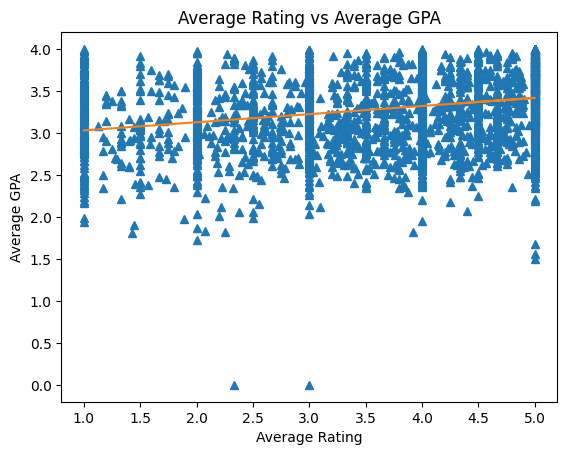

In [60]:
x = both_avg_df["average_rating"]
y = both_avg_df["average_gpa"]
reg = linear_model.LinearRegression()
x_train = [[x] for x in both_avg_df["average_rating"].values]
y_train = [[y] for y in both_avg_df["average_gpa"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.close()
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Rating vs Average GPA")
plt.ylabel("Average GPA")
plt.xlabel("Average Rating")
plt.show()

It looks like a majority of the data points are all at either a rating of one of the whole numbers. This is likely due to a lot of professors only having very little reviews for a specific class, leading the sample size to be extremely small. In this case, we can then make our data only include classes for which a professor has five or more reviews.

In [61]:
# getting rid of professor/class combinations with less than 5 reviews

five_or_more_df = pd.DataFrame()
count = 0

for index, row in both_avg_df.iterrows():
    if both_avg_df.at[index, "num_ratings"] >= 5:
        five_or_more_df.at[count, "name"] = both_avg_df.at[index, "name"]
        five_or_more_df.at[count, "slug"] = both_avg_df.at[index, "slug"]
        five_or_more_df.at[count, "course"] = both_avg_df.at[index, "course"]
        five_or_more_df.at[count, "average_rating"] = both_avg_df.at[index, "average_rating"]
        five_or_more_df.at[count, "num_ratings"] = both_avg_df.at[index, "num_ratings"]
        five_or_more_df.at[count, "average_gpa"] = both_avg_df.at[index, "average_gpa"]
        five_or_more_df.at[count, "num_students"] = both_avg_df.at[index, "num_students"]
        count = count + 1

five_or_more_df.head()

,name,slug,course,average_rating,num_ratings,average_gpa,num_students
0,A.U. Shankar,shankar_a.u.,CMSC216,2.222222,18.0,2.357948,692.0
1,A.U. Shankar,shankar_a.u.,CMSC412,3.200000,5.0,2.809319,279.0
2,Aaron Finkle,finkle,ECON306,2.500000,8.0,2.706983,2678.0
3,Aaron Swanlek,swanlek,COMM107,5.000000,7.0,3.938579,394.0
4,Abigail Nicolas,nicolas_abigail,PSYC221,5.000000,8.0,3.557846,325.0


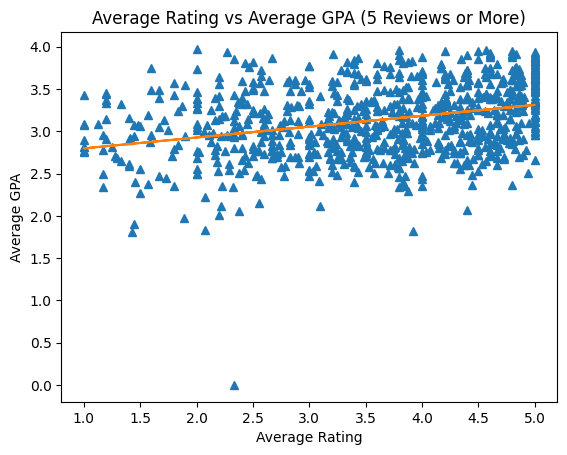

In [62]:
x = five_or_more_df["average_rating"]
y = five_or_more_df["average_gpa"]
reg = linear_model.LinearRegression()
x_train = [[x] for x in five_or_more_df["average_rating"].values]
y_train = [[y] for y in five_or_more_df["average_gpa"].values]
regfit = reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
plt.plot(x, y, "^")
plt.plot(x_train,y_pred)
plt.title("Average Rating vs Average GPA (5 Reviews or More)")
plt.ylabel("Average GPA")
plt.xlabel("Average Rating")
plt.show()

Now there is less concentration of our data at these values. There appears to be a general positive trend and slight relationship between the average rating of a professor class combination and the average GPA for that same combination. However, in order to gain more insight into whether or not this is a consistent trend, it would be nice to hold some things constant. We would like to see if this trend continues for a single professor teaching different classes or for different professors teaching the same class.

There are 14 professors teaching 4 or more classes that have 5 or more reviews at UMD. In order to avoid small sample sizes, we will analyze these 14 professors, and see if there is any relationship between reviews and GPA for the classes that they teach.

In [65]:
multi_prof = {}
curr_prof = None
classes = [[]]
multi = False
for index, row in five_or_more_df.iterrows():
    # gets all of the professors that teach multiple classes
    classes.append([five_or_more_df.at[index, "course"],
                    five_or_more_df.at[index, "average_rating"],
                    five_or_more_df.at[index, "num_ratings"],
                    five_or_more_df.at[index, "average_gpa"],
                    five_or_more_df.at[index, "num_students"]])
    if five_or_more_df.at[index, "name"] == curr_prof:
        multi = True
    else:
        if multi == True:
            multi_prof[curr_prof] = classes
            multi = False
        classes = []
        curr_prof = five_or_more_df.at[index, "name"]

# puts all of these professors in a dataframe, sorting them by number of classes they teach
multi_prof_df = pd.DataFrame()

count = 0
for i in multi_prof.keys():
    multi_prof_df.at[count, "name"] = i
    multi_prof_df.at[count, "num_classes"] = len(multi_prof.get(i))
    count = count + 1

multi_prof_df = multi_prof_df.sort_values(by = "num_classes", ascending = False, ignore_index = True)

# copy over the information for the 14 professors with the most classes
most_classes_profs = []

for i in range(14):
    most_classes_profs.append(multi_prof_df.at[i, "name"])

most_classes_profs_df = pd.DataFrame()
count = 0

for index, row in five_or_more_df.iterrows():
    if five_or_more_df.at[index, "name"] in most_classes_profs:
        most_classes_profs_df.at[count, "name"] = five_or_more_df.at[index, "name"]
        most_classes_profs_df.at[count, "course"] = five_or_more_df.at[index, "course"]
        most_classes_profs_df.at[count, "average_rating"] = five_or_more_df.at[index, "average_rating"]
        most_classes_profs_df.at[count, "num_ratings"] = five_or_more_df.at[index, "num_ratings"]
        most_classes_profs_df.at[count, "average_gpa"] = five_or_more_df.at[index, "average_gpa"]
        most_classes_profs_df.at[count, "num_students"] = five_or_more_df.at[index, "num_students"]
        count = count + 1

most_classes_profs_df.head()

,name,course,average_rating,num_ratings,average_gpa,num_students
0,Bonnie Dixon,BCHM463,2.666667,12.0,2.769094,1291.0
1,Bonnie Dixon,CHEM131,3.842105,19.0,2.707407,243.0
2,Bonnie Dixon,CHEM134,2.166667,6.0,2.723111,225.0
3,Bonnie Dixon,CHEM135,3.758621,29.0,2.612654,893.0
4,Bonnie Dixon,CHEM231,4.205882,68.0,2.730612,2829.0


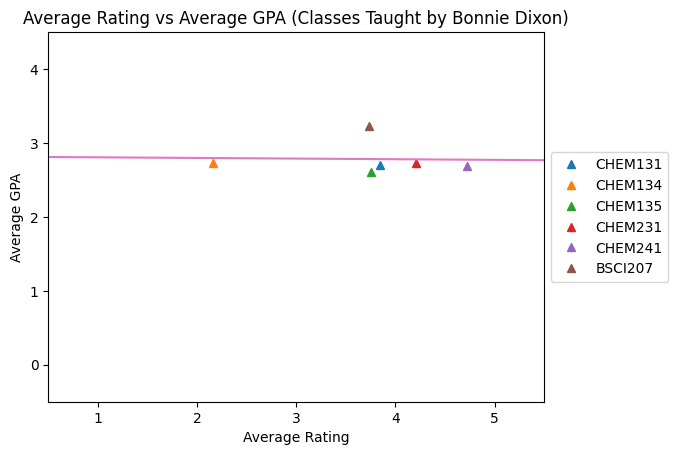

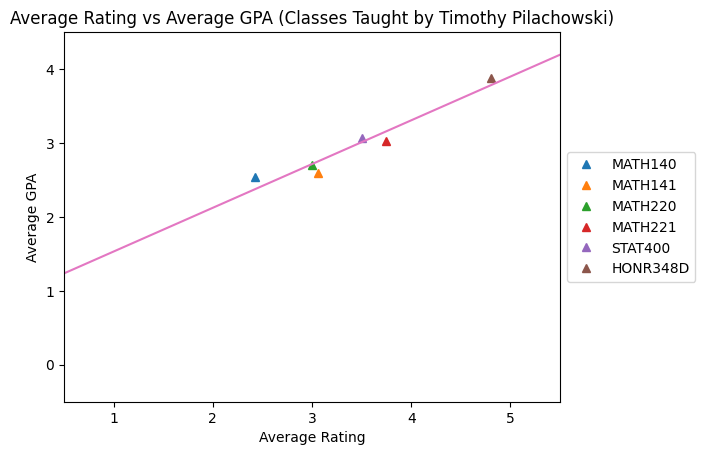

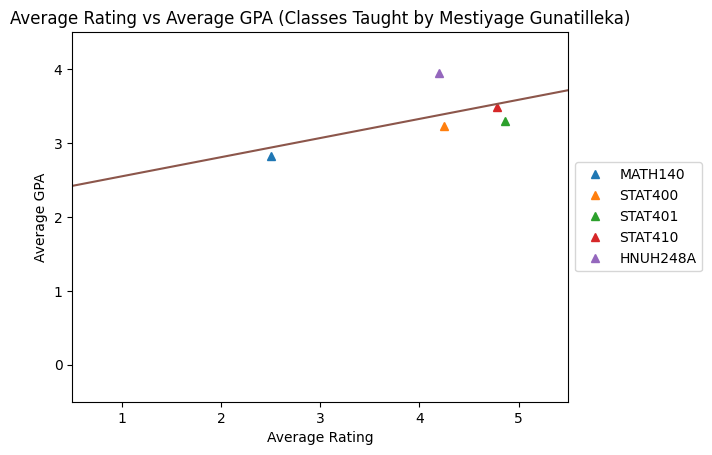

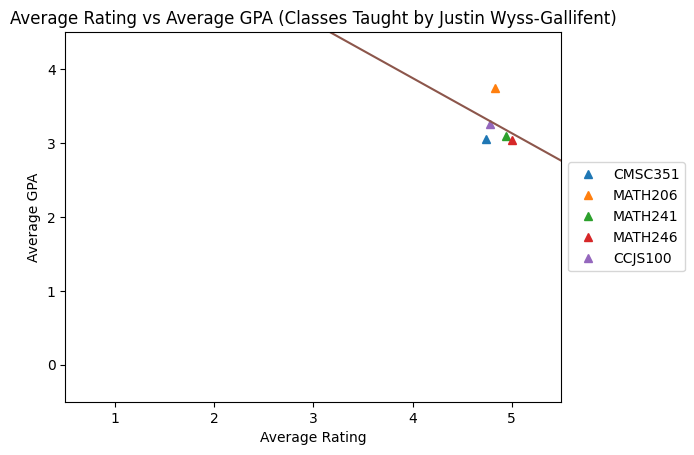

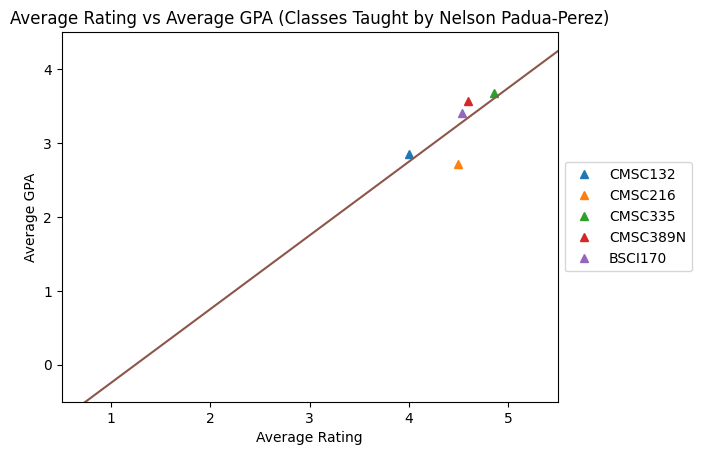

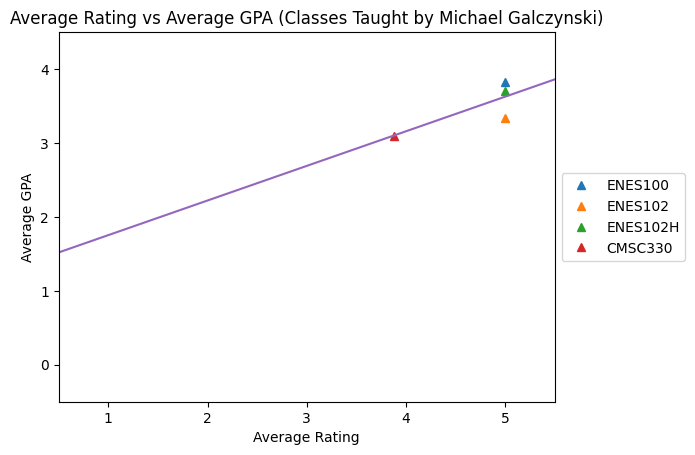

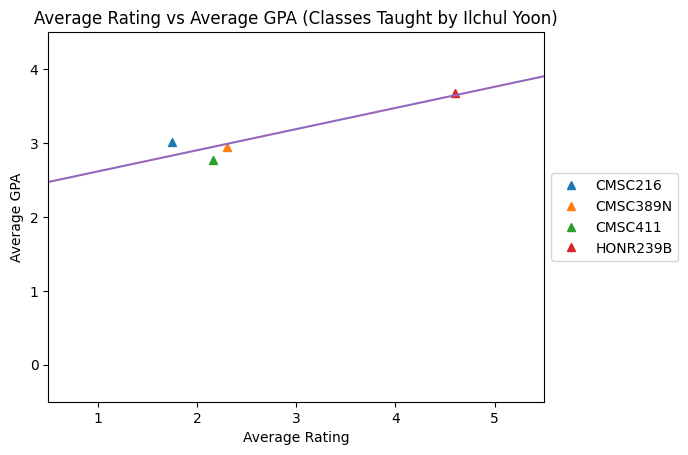

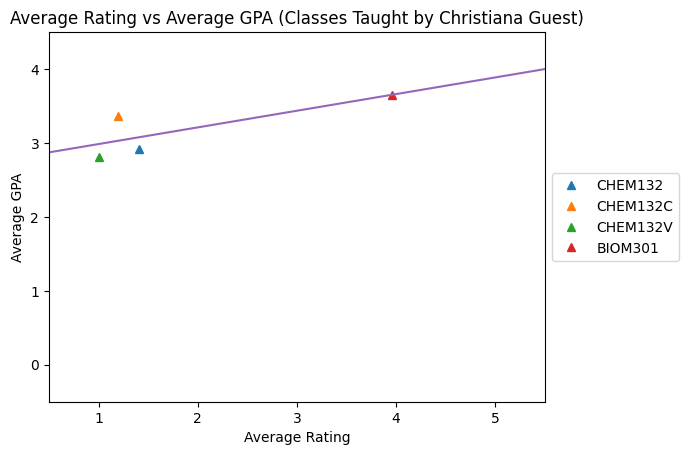

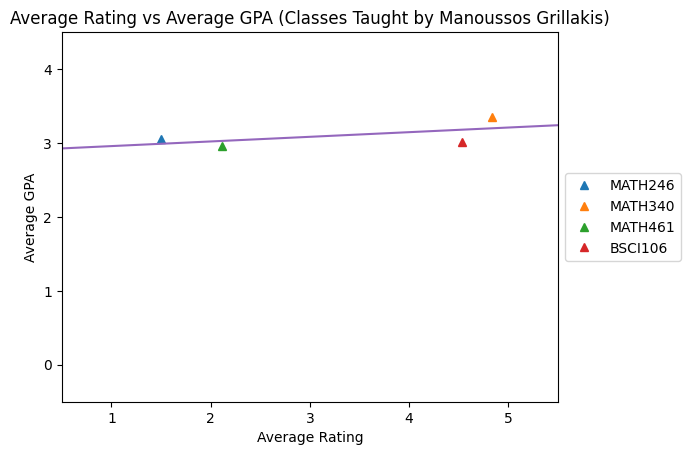

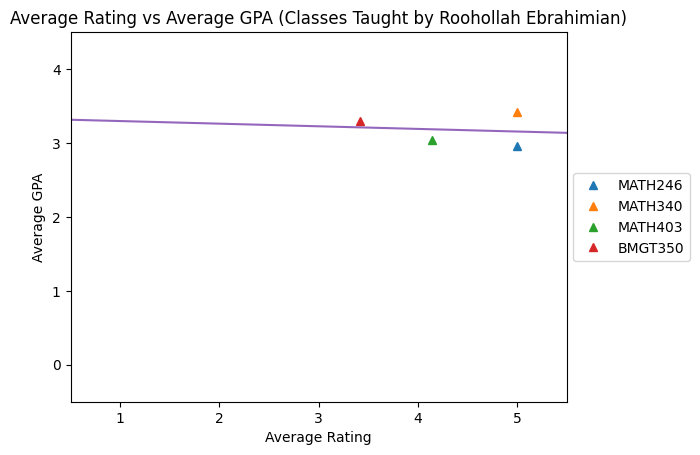

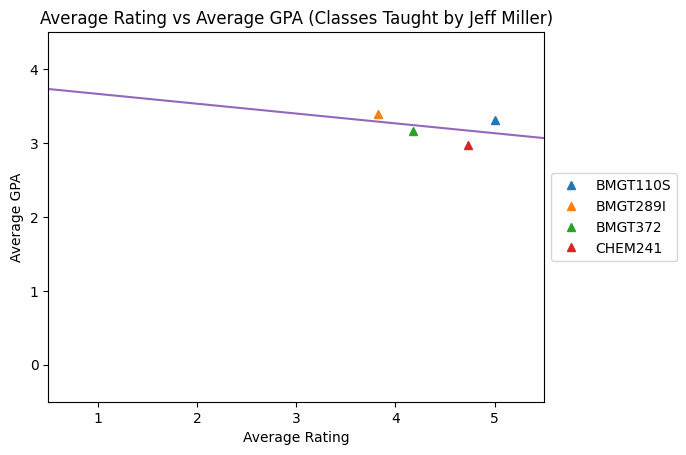

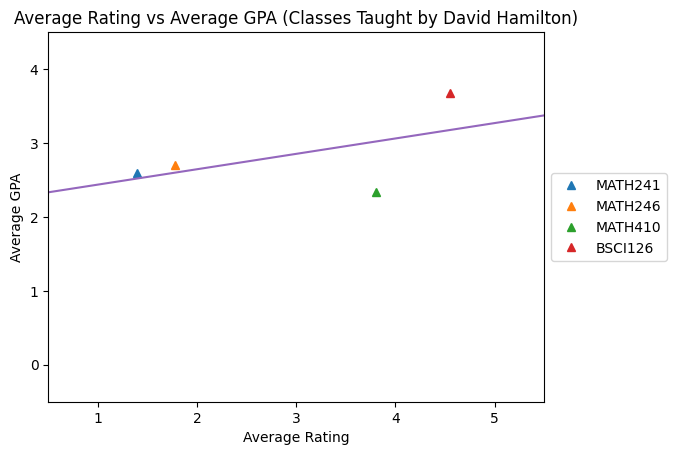

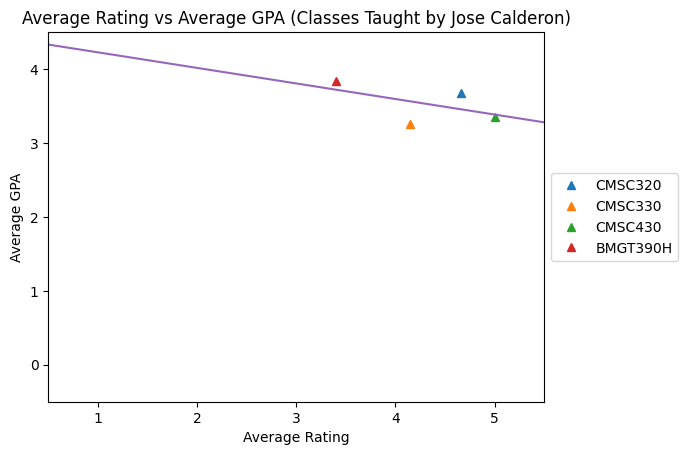

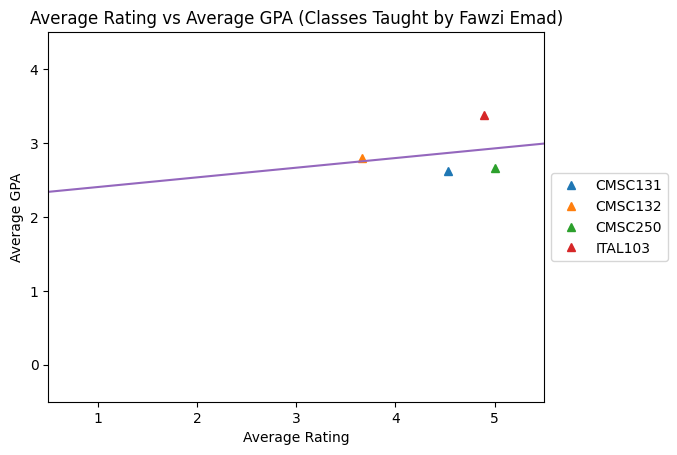

In [66]:
for i in most_classes_profs:
    courses = []
    ratings = []
    gpas = []

    # store all of the course information for each professor
    for j in multi_prof.get(i):
        courses.append(j[0])
        ratings.append(j[1])
        gpas.append(j[3])

    for j in range(len(courses)):
        plt.plot(ratings[j], gpas[j], "^", label = courses[j])

    plt.title("Average Rating vs Average GPA (Classes Taught by " + i + ")")
    plt.ylabel("Average GPA")
    plt.xlabel("Average Rating")
    plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
    # linear regression for each professor
    ratings = np.array(ratings).reshape(-1, 1)
    reg = linear_model.LinearRegression()
    regfit = reg.fit(ratings, gpas)
    X = np.linspace(-100, 100)
    y_pred = reg.predict(np.array(X).reshape(-1,1))
    plt.plot(X,y_pred)
    plt.xlim(0.5, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.show()

It appears that, in general, there is either little to no correlation between average rating and average GPA for differnet classes taught by the same professor. This is most prominent in professors that have a large range of ratings, such as Timothy Pilachowski and Ichul Yoon. The few exceptions, namely Justin Wyss-Gallifent and Jose Calderon both have very high ratings in general, limiting the spread of their ratings and thus the information that the calculated regression has to go on.

Now, we would like to perform the same task, except see if different professors teaching the same class will result in different average ratings and GPAs. There are 10 classes that have been taught by 9 or more professors, each with 5 or more reviews on PlanetTerp.

In [70]:
multi_course = {}
curr_course = None
profs = [[]]
multi = False

# get all of the classes that have been taught by multiple professors
five_or_more_df = five_or_more_df.sort_values(by = "course", ignore_index = True)

for index, row in five_or_more_df.iterrows():
    profs.append([five_or_more_df.at[index, "name"],
                    five_or_more_df.at[index, "average_rating"],
                    five_or_more_df.at[index, "num_ratings"],
                    five_or_more_df.at[index, "average_gpa"],
                    five_or_more_df.at[index, "num_students"]])
    if five_or_more_df.at[index, "course"] == curr_course:
        multi = True
    else:
        if multi == True:
            multi_course[curr_course] = profs
            multi = False
        profs = []
        curr_course = five_or_more_df.at[index, "course"]

five_or_more_df = five_or_more_df.sort_values(by = "name", ignore_index = True)

# store those classes in a dataframe and sort it by number of professors that have taught it
multi_course_df = pd.DataFrame()

count = 0
for i in multi_course.keys():
    multi_course_df.at[count, "course"] = i
    multi_course_df.at[count, "num_profs"] = len(multi_course.get(i))
    count = count + 1

multi_course_df = multi_course_df.sort_values(by = "num_profs", ascending = False, ignore_index = True)

# keep only the 10 courses that have been taught by the most professors
most_profs_courses = []

for i in range(10):
    most_profs_courses.append(multi_course_df.at[i, "course"])

most_profs_courses_df = pd.DataFrame()
count = 0

for index, row in five_or_more_df.iterrows():
    if five_or_more_df.at[index, "course"] in most_profs_courses:
        most_profs_courses_df.at[count, "name"] = five_or_more_df.at[index, "name"]
        most_profs_courses_df.at[count, "course"] = five_or_more_df.at[index, "course"]
        most_profs_courses_df.at[count, "average_rating"] = five_or_more_df.at[index, "average_rating"]
        most_profs_courses_df.at[count, "num_ratings"] = five_or_more_df.at[index, "num_ratings"]
        most_profs_courses_df.at[count, "average_gpa"] = five_or_more_df.at[index, "average_gpa"]
        most_profs_courses_df.at[count, "num_students"] = five_or_more_df.at[index, "num_students"]
        count = count + 1

most_profs_courses_df.head()

,name,course,average_rating,num_ratings,average_gpa,num_students
0,Aaron Swanlek,COMM107,5.000000,7.0,3.938579,394.0
1,Alice Mignerey,CHEM131,2.023256,43.0,2.752637,1896.0
2,Amanda Allen,ENGL101,4.111111,9.0,3.275768,879.0
3,Amanda Schech,CHEM135,4.166667,6.0,2.678378,37.0
4,Amanda Schech,CHEM131,3.266667,15.0,2.712098,1463.0


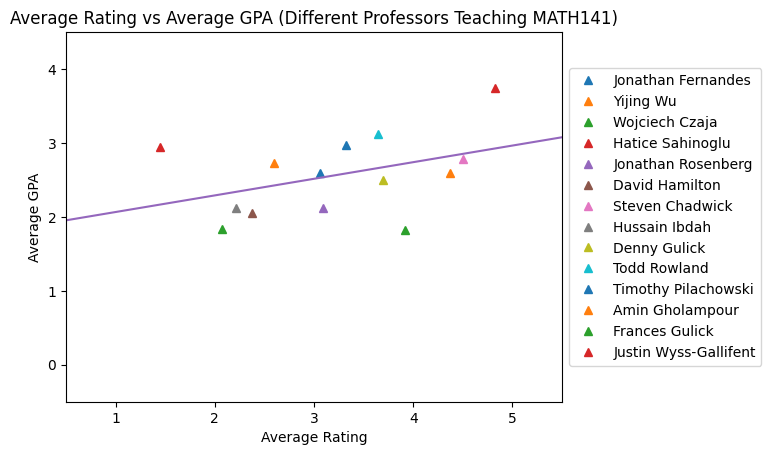

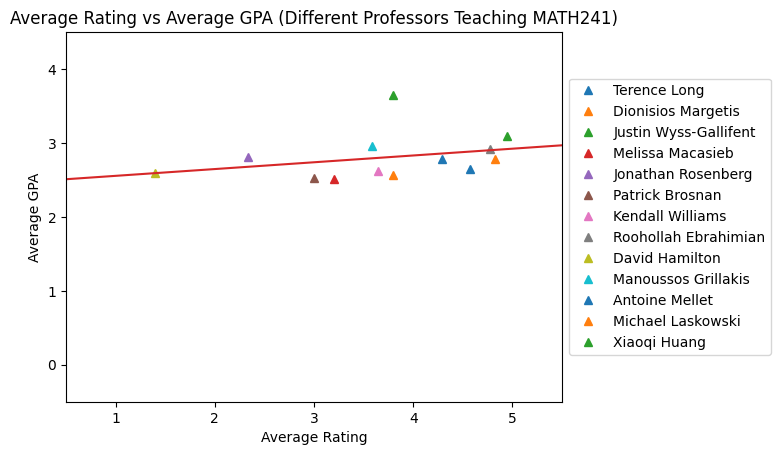

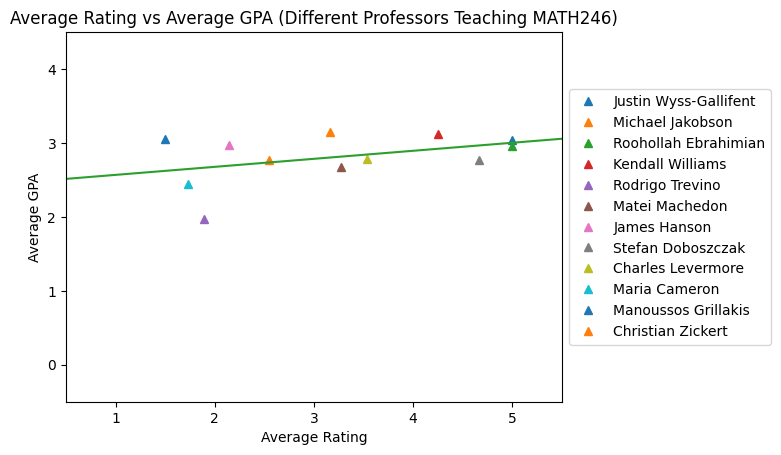

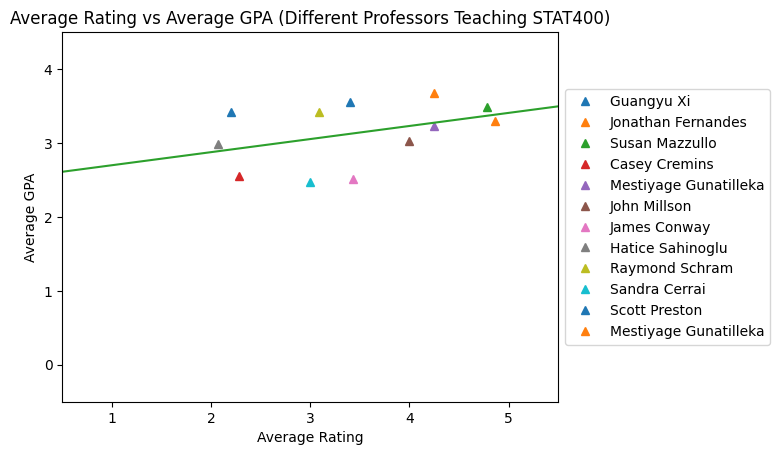

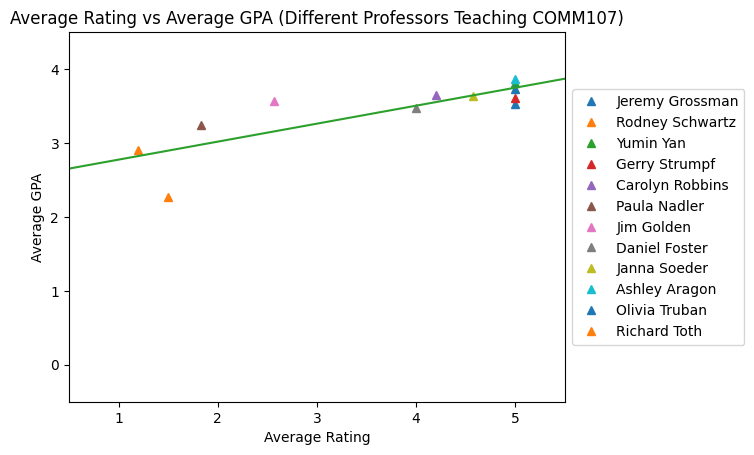

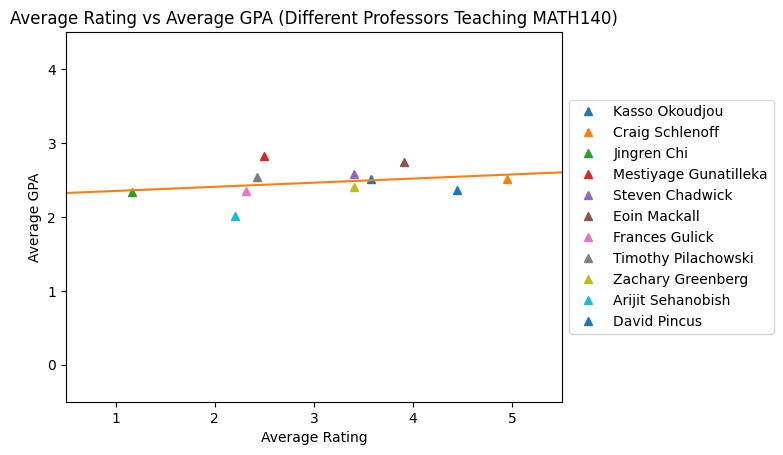

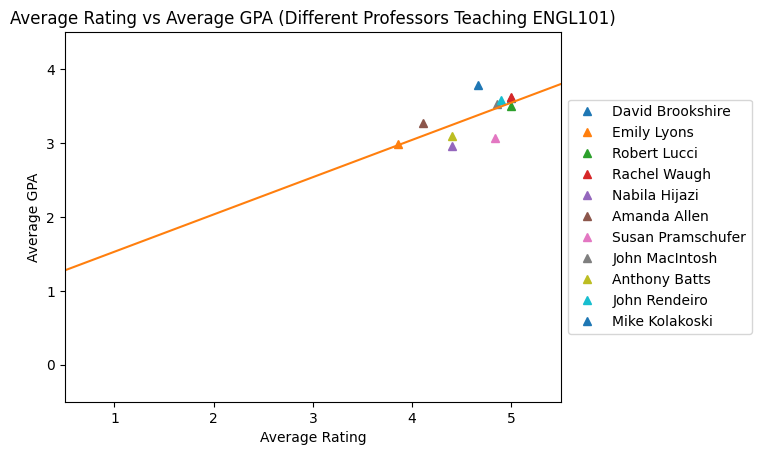

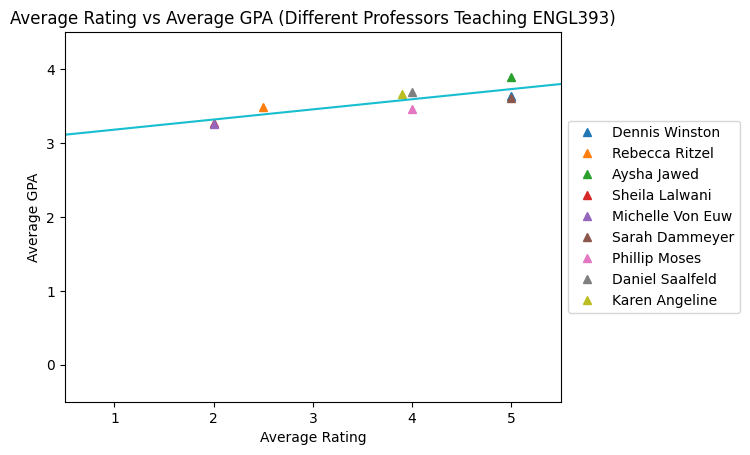

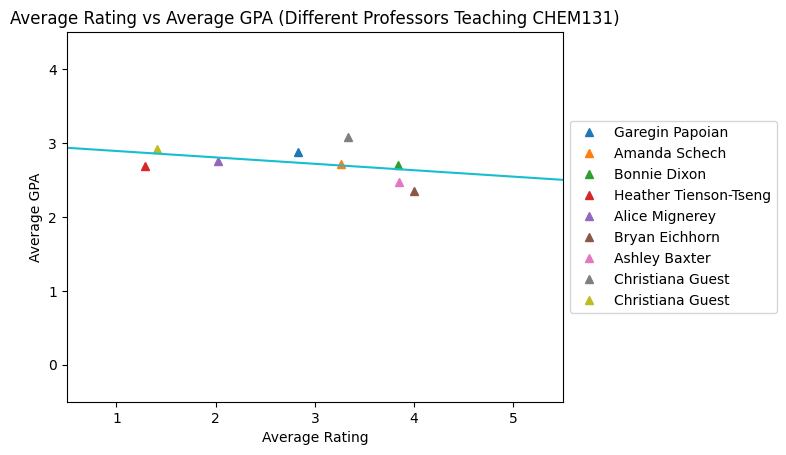

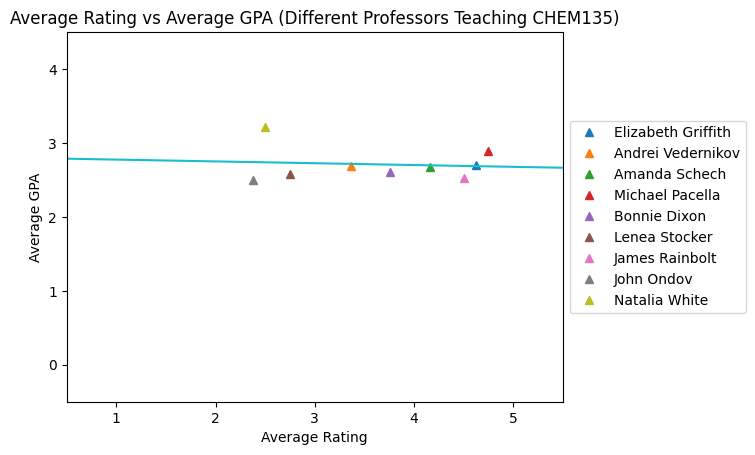

In [71]:
for i in most_profs_courses:
    profs = []
    ratings = []
    gpas = []

    # get all of the information for each professor that has taught the class
    for j in multi_course.get(i):
        profs.append(j[0])
        ratings.append(j[1])
        gpas.append(j[3])

    for j in range(len(profs)):
        plt.plot(ratings[j], gpas[j], "^", label = profs[j])

    plt.title("Average Rating vs Average GPA (Different Professors Teaching " + i + ")")
    plt.ylabel("Average GPA")
    plt.xlabel("Average Rating")
    plt.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
    # linear regression for gpa vs rating
    ratings = np.array(ratings).reshape(-1, 1)
    reg = linear_model.LinearRegression()
    regfit = reg.fit(ratings, gpas)
    X = np.linspace(-100, 100)
    y_pred = reg.predict(np.array(X).reshape(-1,1))
    plt.plot(X,y_pred)
    plt.xlim(0.5, 5.5)
    plt.ylim(-0.5, 4.5)
    plt.show()

Again, there seems to generally be either a trend where higher ratings correlates to higher GPAs or little to no correlation at all. There is generally a higher range of ratings for each class, meaning that the regressions have more data to be trained on and are thus more reliable. Altogether, there is not sufficient evidence to say that there is any correlation between ratings and GPA in general, as a consistent trend has not been exhibited.

### Sentiment Analysis